In [1]:
import numpy as np

In [2]:
import openpiv_cxx
from openpiv_cxx import process as proc
from openpiv_cxx import windef as piv_wdf
from openpiv_cxx import tools as piv_tls

In [3]:
from matplotlib import pyplot as plt

In [4]:
def run_test():
    errors = {
        "taylor expansions_1": [],
        "taylor expansions_3": [],
        "taylor expansions_5": [],
        "taylor expansions_7": [],
        "whittaker-shanon_5": [],
        "whittaker-shanon_7": []
    }
    
    real_disp = 0
    n = 1/32
    
    folder = "../synthetic_tests/vel_magnitude"
    file = "/vel_{}{}.bmp"

    window_size = 32
    overlap = 16
        
    for i in range(64):    
        frame_a = piv_tls.imread(folder + file.format(i, "a"))
        frame_b = piv_tls.imread(folder + file.format(i, "b"))
        
        x_, y_, u, v, _ = piv_wdf.first_pass(
            frame_a, 
            frame_b,
            window_size,
            overlap, 
            correlation_method = "circular"
        )

        passes = 2
        interp_meths = [
            ["taylor expansions", [1,3,5,7]],
            ["whittaker-shanon", [5, 7]]
        ]
        
        for method in interp_meths:
            for order in method[1]:
                u1 = u.copy()
                v1 = v.copy()
                
                for _ in range(passes):
                    _, _, u1, v1, _ = piv_wdf.multipass_img_deform(
                        frame_a, 
                        frame_b,
                        x_, y_, 
                        u1, v1, 
                        window_size,
                        overlap,
                        deformation_algorithm=method[0],
                        order=order,
                        radius=order
                    )

                err = real_disp - np.nanmean(np.hypot(u1, v1))
                errors[method[0] + f"_{order}"].append(err)

        real_disp += n
    return errors

In [5]:
errors = run_test()

"\nplt.savefig(\n    'openpiv_deform_algos.jpeg',\n    dpi = 300\n)\n#"

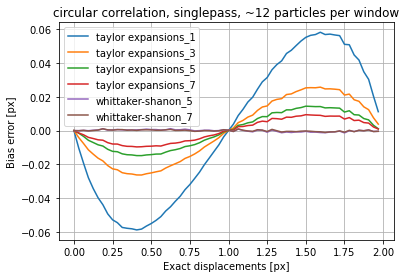

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

legend = []

ax.set_title('circular correlation, singlepass, ~12 particles per window')
ax.set_ylabel('Bias error [px]')
ax.set_xlabel('Exact displacements [px]')
ax.grid(True)
n = 1/32

for err_key in errors:
    arr = np.array(errors[err_key])
    ax.plot(np.mgrid[0:len(arr)/32:n], arr)
    legend.append(err_key)

ax.legend(
    legend,
    ncol = 1,
    loc = 'upper left'
)
'''
plt.savefig(
    'openpiv_deform_algos.jpeg',
    dpi = 300
)
#'''

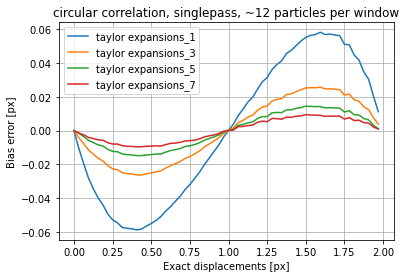

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

legend = []

ax.set_title('circular correlation, singlepass, ~12 particles per window')
ax.set_ylabel('Bias error [px]')
ax.set_xlabel('Exact displacements [px]')
ax.grid(True)
n = 1/32

for err_key in errors:
    if err_key not in ["whittaker-shanon_5", "whittaker-shanon_7"]:
        arr = np.array(errors[err_key])
        ax.plot(np.mgrid[0:len(arr)/32:n], arr)
        legend.append(err_key)

ax.legend(
    legend,
    ncol = 1,
    loc = 'upper left'
)

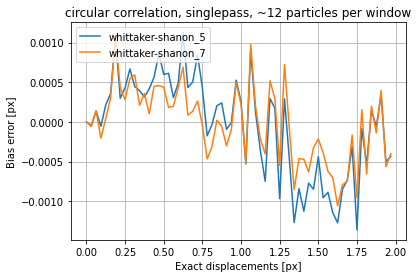

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

legend = []

ax.set_title('circular correlation, singlepass, ~12 particles per window')
ax.set_ylabel('Bias error [px]')
ax.set_xlabel('Exact displacements [px]')
ax.grid(True)
n = 1/32

for err_key in errors:
    if err_key not in ["taylor expansions_1", "taylor expansions_3",
                       "taylor expansions_5", "taylor expansions_7"]:
        arr = np.array(errors[err_key])
        ax.plot(np.mgrid[0:len(arr)/32:n], arr)
        legend.append(err_key)

ax.legend(
    legend,
    ncol = 1,
    loc = 'upper left'
)

In [13]:
def performance_test():
    from time import time
    
    img_a = "../synthetic_tests/vel_magnitude/vel_32a.bmp"
    img_b = "../synthetic_tests/vel_magnitude/vel_32b.bmp"
    frame_a = piv_tls.imread(img_a)
    frame_b = piv_tls.imread(img_b)
    window_size = 32
    overlap = 24
    
    average_time = {
        "taylor expansions_1": [],
        "taylor expansions_3": [],
        "taylor expansions_5": [],
        "taylor expansions_7": [],
        "whittaker-shanon_5": [],
        "whittaker-shanon_7": []
    }
    
    reps = 10
    interp_meths = [
            ["taylor expansions", [1,3,5,7]],
            ["whittaker-shanon", [5, 7]]
        ]
    
    x, y, u, v, _ = piv_wdf.first_pass(
            frame_a, 
            frame_b,
            window_size,
            overlap, 
            correlation_method = "circular"
        )
        
    for method in interp_meths:
        for order in method[1]:
            start = time()
            
            for _ in range(reps):
                _ = piv_wdf.deform_windows(
                    frame_a, 
                    frame_b,
                    x, y, 
                    u, v, 
                    deformation_method=method[0],
                    order=order,
                    radius=order
                )
                
            end = (time() - start) / reps
            average_time[method[0] + f"_{order}"].append(end)
    return average_time  

In [14]:
becnhmark = performance_test()

<BarContainer object of 6 artists>

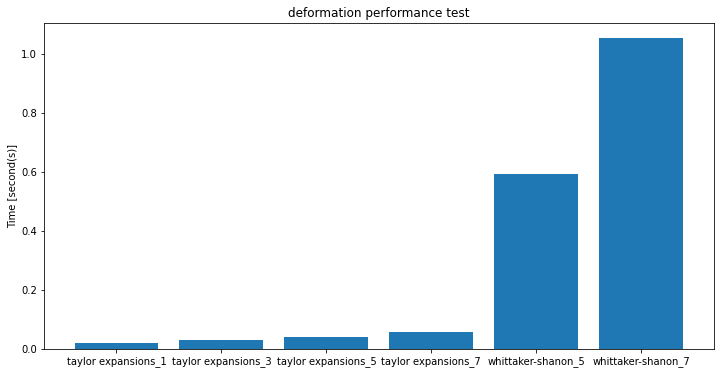

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.set_title('deformation performance test')
ax.set_ylabel('Time [second(s)]')
keys = list(becnhmark.keys())
values = np.array(list(becnhmark.values())).reshape(-1)

ax.bar(keys, values)